## lab3

### 实验目标

在 上一次实验 中，我们通过使用 `PyTorch Geometric` 内置的 `GCN` 层构建了 `GNN` 模型， `GCNConv` 。在本次实验中，我们将进一步深入，实现 `GraphSAGE`层。然后，将模型运行在 `CORA` 数据集上（一个标准的`citation network`基准数据集）。

### 实验说明

1. 需要大家完成的任务是加粗且带有得分的题目，如 `问题 i：XXXXXXX（15分）`
2. 做完实验后，请举手通知助教检查实验代码以及问题的输出结果，以便给同学们进行打分
3. 如果大家有疑问尽量在实验课的前60分钟提出，后30分钟主要用于检查同学们的实验结果，可能时间没那么充裕
3. 本次实验没有评分的实验任务，所有任务都会提供参考答案。同学们只需要按照参考答案的实现或者自行思考实现，将控制台输出给助教展示供助教打分即可。

### 实验过程

（1）安装实验所需依赖包

- pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
- pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
- pip install torch-geometric

如果大家想用CPU来跑，请参考文章：https://blog.csdn.net/dream__1/article/details/122433061

（2）整体任务说明：实现 `Layer Modules`

> 本次实验基于一个通用的图神经网络栈进行构建，我们可以在其中插入自己的模块实现：`GraphSAGE 和 GAT`（本次实验中，我们只实现`GraphSAGE`）。
>
> 然后，我们将完成 `CORA` 数据集上的节点分类，`CORA` 是一个标准的` citation network`基准。在这个数据集中，节点对应文档，边对应无向引用。图中的每个节点或文档都被分配了一个基于文档二值化词袋表示的类别标签和特征。具体来说，Cora 图有 2708 个节点，5429 条边，7 个预测类别，每个节点有 1433 个特征。

（3）`GNN Stack Module`

> 下面是一个通用 `GNNStack` 的实现，我们可以插入任何 `GNN` 层，如 `GraphSage、GAT `等。你对 `GraphSage`（本次实验的任务）层的实现将作为 `GNNStack `模块的组件。


In [1]:
import torch
print(torch.__version__)       # PyTorch 版本
print(torch.version.cuda)      # 编译时支持的 CUDA 版本
print(torch.cuda.is_available())  # 检查 CUDA 是否可用
print(torch.cuda.current_device()) # 当前使用的 GPU 设备编号
print(torch.cuda.get_device_name(0)) # 当前 GPU 名称（如有多卡可换编号）

2.7.0+cu126
12.6
True
0
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [2]:

import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn.conv import MessagePassing

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x # 返回节点嵌入

        return F.log_softmax(x, dim=1) # 返回分类结果

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

（4）创建`Message Passing Layer`

> 本节中我们需要了解`Pytorch` 消息传递层的实现细节，从而构建自己的图神经网络模型。为此，我们将使用并实现 定义 `PyG `消息传递层所需的 3 个关键函数： `forward` ， `message` ，和 `aggregate` 。

**什么是消息传递？**

我们关注与单个中心节点 x 相关的单轮消息传递。在消息传递之前， x 与特征向量$x^{l-1}$相关联，消息传递的目的是更新这个特征向量$ x^l $。

 为此，需要执行以下步骤：

1. 每个相邻节点 v 通过边 (x,v) 传递其当前消息 $v^{l−1}$
2. 对于节点 x ，我们聚合相邻节点的所有消息（例如通过求和或平均值）
3. 通过例如应用线性和非线性变换来转换聚合信息。

总的来说，消息传递过程被应用于我们的图中的每个节点 u ，u 通过作为上述步骤 1-3 中描述的中心节点 x 来更新其嵌入。

现在，我们将此过程扩展到单层消息传递，消息传递层的任务是更新图中每个节点的当前特征表示或嵌入，通过在图中传播和转换信息来实现。总的来说，消息传递层的一般范式是：1）预处理 -> 2）消息传递/传播 -> 3）后处理。

具体的`forward` 函数处理节点特征/嵌入的预处理和后处理，并通过调用 `propagate` 函数来启动消息传递。`propagate` 函数封装了消息传递过程！它通过调用三个重要的函数来实现：1) `message` ，2) `aggregate` ，和 3) `update` 。我们的实现与这个略有不同（我们不会显式地实现 `update` ，而是在 `forward` 函数中放置更新节点嵌入的逻辑）。更具体地说，在信息传递之后，我们可以进一步转换由 `propagate` 输出的节点嵌入。因此， `forward` 的输出正好是经过一个 `GNN` 层后的节点嵌入。

> 了解上述函数

In [ ]:
# def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
    # edge_index 传递给 forward 函数并捕获图的边结构。
    # x = (x_i, x_j) 表示将要用于消息传递的节点特征。为了解释为什么传递元组 (x_i, x_j) ，我们首先看看我们的边是如何表示的。对于每条边 (i,j) ∈ E，我们可以区分 i 为源节点（x_central）和 j 为相邻节点（x_neighbor）。
    # 以上面的消息传递为例，对于中心节点 u ，我们将聚合并转换与节点 v 关联的所有消息，即 (u,v) ∈ E（即 v ∈ Nei_u  ）。因此我们可以看到，下标 _i 和 _j 允许我们具体区分与中心节点（即接收消息信息的节点）和相邻节点（即传递消息的节点）相关的特征。
    # 还有一种理解方式：根据视角的不同，节点 x 可以作为一个中心节点或一个邻近节点。实际上，在无向图中，我们存储了边的两个方向（即 (i,j) 和 (j,i)）。从中心节点的角度来看x_i，x 正在收集邻近信息以更新其嵌入。从邻近节点的角度来看x_j，x 正在沿着连接到不同中心节点的边传递其消息信息。
    # extra=(extra_i, extra_j) 代表我们可以与每个节点关联的除其当前特征嵌入之外的信息。实际上，我们可以包含我们想要的任何形式的额外参数 param=(param_i, param_j) 。再次强调，使用 _i 和 _j 进行索引使我们能够区分中心和邻近节点。

    # 函数 propagate 的输出是消息传递过程后的节点嵌入矩阵，形状为  [N,d]  。


SyntaxError: incomplete input (39450949.py, line 8)

In [ ]:
# def message(x_j, ...):
    # message 函数由 propagate 调用，并从相邻节点 j 到中心节点 i 为每条边 (i,j)  在 edge_index 中构建消息。此函数可以接受最初传递给 propagate 的任何参数。此外，我们还可以通过在变量名后附加 _i 或 _j 来再次区分中心节点和相邻节点，例如 x_i 和 x_j 。更具体地看变量，我们有：
    # x_j 代表所有相邻节点通过各自的边传递消息的特征嵌入矩阵（即所有节点 j 对于边  (i,j) ∈ E），因此其形状为  [|E|,d]

    # message 函数的输出是一个邻接节点嵌入矩阵，准备进行聚合，其形状为  [|E|,d]


In [ ]:
# def aggregate(self, inputs, index, dim_size = None):
    #  aggregate 函数用来聚合来自邻接节点的消息
    # inputs 代表从邻接节点传递的消息矩阵（即 message 函数的输出）
    # index 与 inputs 具有相同的形状，并告诉我们每个行消息 j 在 inputs 矩阵中对应的中心节点。因此， index 告诉我们为每个中心节点聚合哪些行消息。

    # aggregate 的输出形状为 [N,d]


**（5）问题1： `GraphSage` 实现（100分）**

对于给定的中心节点v的嵌入$h_v^{l-1}$,  $ h_v^{l-1} \rightarrow h_v^l$ 的转化规则如下:
$$
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
$$

其中，`W1 和 W2` 是可学习权重矩阵，节点 u 是相邻节点。此外，为简单起见，我们使用平均值聚合：
$$
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
$$
在实施此更新规则之前，需要思考上述公式中的不同部分如何与之前概述的函数相对应：

1) `forward` ，2) `message` ，和 3) `aggregate` 。

> 提示，我们已知聚合函数（即平均聚合），现在的问题是，每个邻居节点传递的消息是什么，以及何时调用 `propagate` 函数？


In [5]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: code here (25分)
	    # 定义 self.lin_l 和 self.lin_r
        # self.lin_l 是应用于中心节点嵌入的线性变换。
        # self.lin_r 是线性变换，用于聚合来自邻居的信息。来自邻居的信息。
        
        self.lin_l = nn.Linear(in_features=in_channels, out_features=out_channels)
        self.lin_r = nn.Linear(in_features=in_channels, out_features=out_channels)

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        out = None

        ############################################################################
        # TODO: code here (35分)
        # 1. 调用 propagate 函数进行消息传递。
        	# 1.1 我们将只使用邻居节点的表示法 (x_j)，因此默认情况下，我们为中心节点和邻居节点传递相同的表示法 x=(x,x)。
        # 2. 用上一层的跳转连接更新节点嵌入。
        # 3. 如果设置了归一化，则进行 L-2 归一化（在 torch.nn.functional 中定义）
        
        out = self.propagate(edge_index=edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize:
            out = F.normalize(out, p=2)

        ############################################################################

        return out

    def message(self, x_j):
        out = None

        ############################################################################
        # TODO: code here (20分)
        # 提示：查看 mean aggregation 函数的表述，关注每个相邻节点传递的信息。

        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None
        node_dim = self.node_dim

        ############################################################################
        # TODO: code here (20分)

        out = torch_scatter.scatter(inputs, index=index, dim=node_dim, dim_size=dim_size, reduce='mean')
        ############################################################################

        return out

（6）构建优化器

In [6]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

（7）训练与测试

In [9]:
import numpy as np
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

def train(dataset, args):
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                     args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            test_accs.append(test_acc)
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = copy.deepcopy(model)
        else:
            test_accs.append(test_accs[-1])

    return test_accs, losses, best_model, best_acc, test_loader


def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
            print("Saving Model Predictions for Model Type", model_type)

            data = {}
            data['pred'] = pred.view(-1).cpu().detach().numpy()
            data['label'] = label.view(-1).cpu().detach().numpy()

            df = pd.DataFrame(data=data)
            # Save locally as csv
            df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)

        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total


class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

（8）打印结果

c:\Users\DreamingLri\.conda\envs\graph_ml\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:31<00:00, 15.98Epochs/s]


Maximum test set accuracy: 0.809
Minimum loss: 0.10183276981115341
Saving Model Predictions for Model Type GraphSage



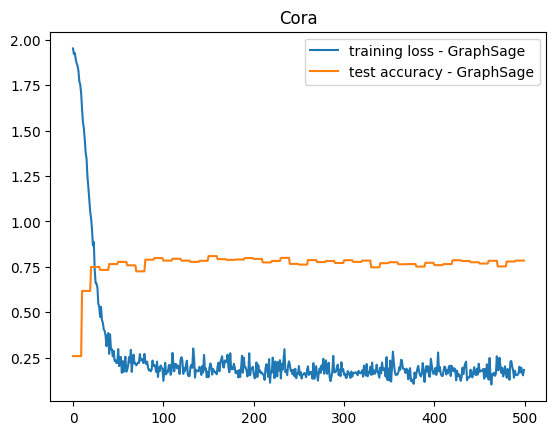

In [10]:
for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage']:
            args.model_type = model

            # Match the dimension.
            args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='./dataset/data1', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset")
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args)

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()